The goal of this notebook is to illustrate the steps that I took to collect, clean and manipulate date, and to test out modeling algorithms to see if we can predict stock price movements. In the data portion, in addition to feature engineering, I expect to manipulate data to get several different data sets to put into the modeling algorithms. In the modeling portion, I will benchmark the model performance, then see if I can beat the benchmark with more advanced and complicated algos.

Several Questions we want to answer:
1. Is model performance highly dependent on individual stocks
2. Does feature engineering improve modeling performance
3. Does advanced modeling algos (ie. deep learning) perform that much better? cost vs. performance tradeoff.

In [171]:
import numpy as np
import pandas as pd
from time import gmtime, strftime, time

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score 

from sklearn.linear_model import Lasso
import xgboost as xgb

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.wrappers.scikit_learn import KerasRegressor

import matplotlib.pyplot as plt
import seaborn as sns

from Extract_Data import extract_data

Before running the extract_data function, don't forget to update the data with the latest at finance.yahoo.com

In [172]:
pca, PCA_df, df = extract_data('AAPL')
PCA_df_rand = shuffle(PCA_df, random_state = 0)
df_rand = shuffle(df, random_state = 0)

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError

In [173]:
print(df.shape)
df.head()

(7213, 17)


,Open,High,Low,Close,Adj Close,Volume,Range,MA5 Adj Close,MA5 Volume,MA5 Adj Close pct_change,MA5 Volume pct_change,Adj Close 1day,Adj Close 5day,Adj Close 1day pct_change,Adj Close 5day pct_change,Adj Close 1day pct_change cls,Adj Close 5day pct_change cls
Date,,,,,,,,,,,,,,,,,
1990-01-09,0.000000,-2.521035,-0.026316,1.343750,0.117058,16.899444,-3.633801,0.117058,17.565719,-1.110223e-16,-3.262988,0.112276,0.108951,-0.043186,-0.073093,0,0
1990-01-10,0.000000,-2.521035,-0.049834,1.285714,0.112276,17.741845,-2.997060,0.117278,17.442342,-4.508983e-02,-2.281949,0.107841,0.104130,-0.041668,-0.076392,0,0
1990-01-11,0.006945,-2.521035,-0.048276,1.232143,0.107841,17.797143,-3.028754,0.116398,17.431083,-7.753950e-02,-2.214844,0.107841,0.101524,0.000000,-0.061597,1,0
1990-01-12,-0.007247,-0.091788,-0.014598,1.232143,0.107841,17.591570,-3.530275,0.114560,17.416669,-6.186253e-02,-2.407701,0.107100,0.107100,-0.007245,-0.007245,0,0
1990-01-15,0.000000,0.763248,-0.007247,1.223214,0.107100,17.530549,-3.133186,0.112645,17.481926,-5.190156e-02,-2.535337,0.108951,0.104130,0.018241,-0.029201,1,0


Getting the datasets ready, separating out the features and labels. Please note that we have 4 datasets:
1. PCA
2. PCA with random order
3. regular dataframe
4. regular dataframe with random order

In [174]:
PCA_rand_X = PCA_df_rand[['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4',
                          'Dimension 5', 'Dimension 6', 'Dimension 7']]
PCA_rand_y = PCA_df_rand[['Adj Close 1day', 'Adj Close 5day',
                          'Adj Close 1day pct_change', 'Adj Close 5day pct_change',
                          'Adj Close 1day pct_change cls', 'Adj Close 5day pct_change cls']]

PCA_X = PCA_df[['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4',
                'Dimension 5', 'Dimension 6', 'Dimension 7']]
PCA_y = PCA_df[['Adj Close 1day', 'Adj Close 5day',
                'Adj Close 1day pct_change', 'Adj Close 5day pct_change',
                'Adj Close 1day pct_change cls', 'Adj Close 5day pct_change cls']]

df_rand_X = df_rand[['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Range', 'MA5 Adj Close', 'MA5 Volume',
                     'MA5 Adj Close pct_change', 'MA5 Volume pct_change']]
df_rand_y = df_rand[['Adj Close 1day', 'Adj Close 5day', 'Adj Close 1day pct_change',
                     'Adj Close 5day pct_change', 'Adj Close 1day pct_change cls',
                     'Adj Close 5day pct_change cls']]

df_X = df[['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Range', 'MA5 Adj Close', 'MA5 Volume',
           'MA5 Adj Close pct_change', 'MA5 Volume pct_change']]
df_y = df[['Adj Close 1day', 'Adj Close 5day', 'Adj Close 1day pct_change',
           'Adj Close 5day pct_change', 'Adj Close 1day pct_change cls',
           'Adj Close 5day pct_change cls']]

Let's take a quick look of the datasets

In [175]:
#df and df rand should look the same
print(df_X.describe())
df_X.head()

              Open         High          Low    Adj Close       Volume  \
count  7213.000000  7213.000000  7213.000000  7213.000000  7213.000000   
mean      0.001041    -0.443064    -0.016626     1.985867    18.164629   
std       0.016744     0.995810     0.016630     1.696235     0.774943   
min      -0.473131    -2.521035    -0.215026     0.101524    13.312205   
25%      -0.004396    -1.074656    -0.023042     0.505926    17.596648   
50%       0.000660    -0.371221    -0.011765     1.249119    18.139357   
75%       0.006352     0.301905    -0.004952     3.557003    18.712434   
max       0.278482     2.681860     0.000000     5.388603    21.364161   

             Range  MA5 Adj Close   MA5 Volume  MA5 Adj Close pct_change  \
count  7213.000000    7213.000000  7213.000000               7213.000000   
mean     -3.594598       1.983804    18.215411                  0.003669   
std       0.604051       1.695188     0.708325                  0.041821   
min      -5.504495       0.10

,Open,High,Low,Adj Close,Volume,Range,MA5 Adj Close,MA5 Volume,MA5 Adj Close pct_change,MA5 Volume pct_change
Date,,,,,,,,,,
1990-01-09,0.000000,-2.521035,-0.026316,0.117058,16.899444,-3.633801,0.117058,17.565719,-1.110223e-16,-3.262988
1990-01-10,0.000000,-2.521035,-0.049834,0.112276,17.741845,-2.997060,0.117278,17.442342,-4.508983e-02,-2.281949
1990-01-11,0.006945,-2.521035,-0.048276,0.107841,17.797143,-3.028754,0.116398,17.431083,-7.753950e-02,-2.214844
1990-01-12,-0.007247,-0.091788,-0.014598,0.107841,17.591570,-3.530275,0.114560,17.416669,-6.186253e-02,-2.407701
1990-01-15,0.000000,0.763248,-0.007247,0.107100,17.530549,-3.133186,0.112645,17.481926,-5.190156e-02,-2.535337


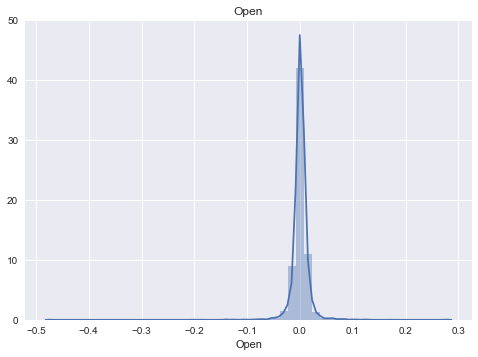

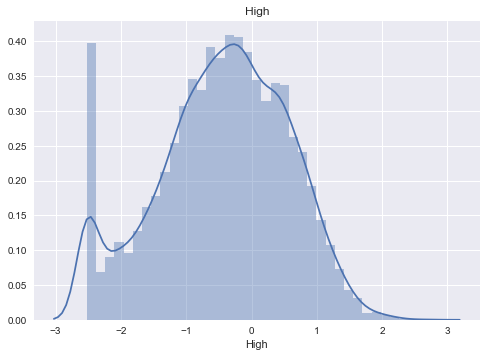

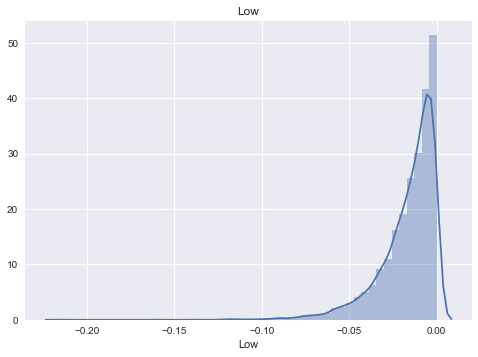

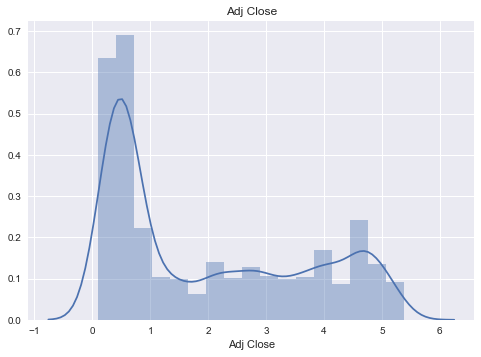

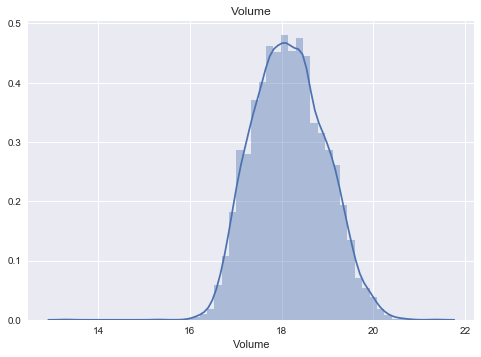

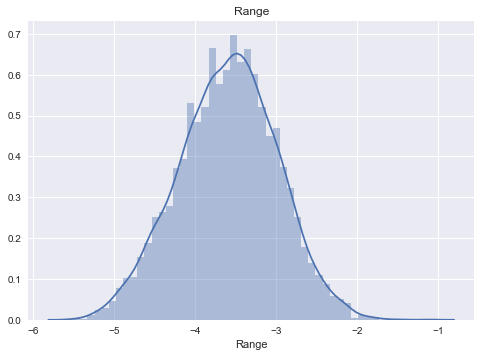

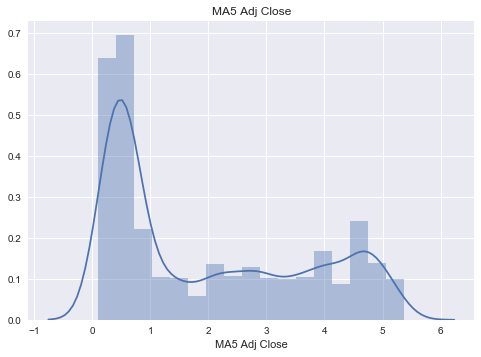

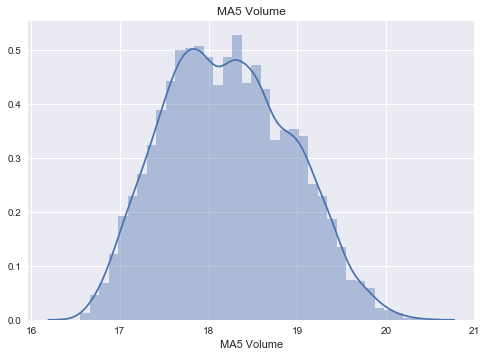

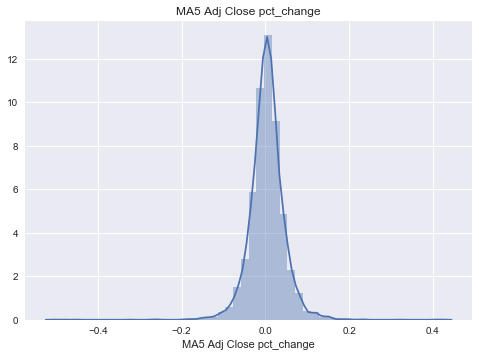

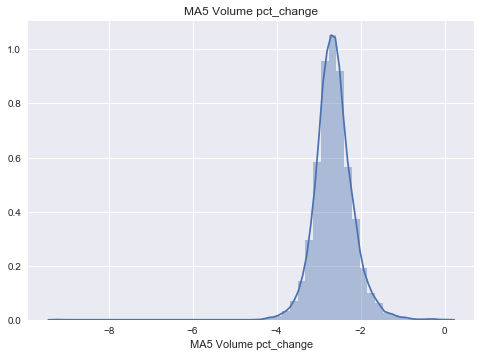

In [176]:
for column in df_X.columns:
    sns.distplot(df_X[column])
    plt.title(column)
    plt.show()

In [177]:
#PCA and PCA rand should look the same
print(df_y.describe())
df_y.head()

       Adj Close 1day  Adj Close 5day  Adj Close 1day pct_change  \
count     7213.000000     7213.000000                7213.000000   
mean         1.986597        1.989529                   0.001450   
std          1.696562        1.697883                   0.028554   
min          0.101524        0.101524                  -0.518691   
25%          0.506469        0.506830                  -0.012559   
50%          1.249979        1.254269                   0.000271   
75%          3.558811        3.562198                   0.014493   
max          5.388603        5.413021                   0.332279   

       Adj Close 5day pct_change  Adj Close 1day pct_change cls  \
count                7213.000000                    7213.000000   
mean                    0.007245                       0.527797   
std                     0.062772                       0.499261   
min                    -0.587617                       0.000000   
25%                    -0.026282                    

,Adj Close 1day,Adj Close 5day,Adj Close 1day pct_change,Adj Close 5day pct_change,Adj Close 1day pct_change cls,Adj Close 5day pct_change cls
Date,,,,,,
1990-01-09,0.112276,0.108951,-0.043186,-0.073093,0,0
1990-01-10,0.107841,0.104130,-0.041668,-0.076392,0,0
1990-01-11,0.107841,0.101524,0.000000,-0.061597,1,0
1990-01-12,0.107100,0.107100,-0.007245,-0.007245,0,0
1990-01-15,0.108951,0.104130,0.018241,-0.029201,1,0


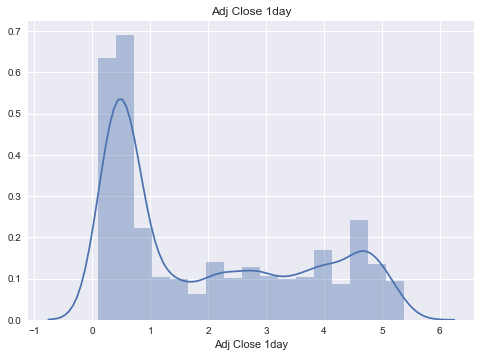

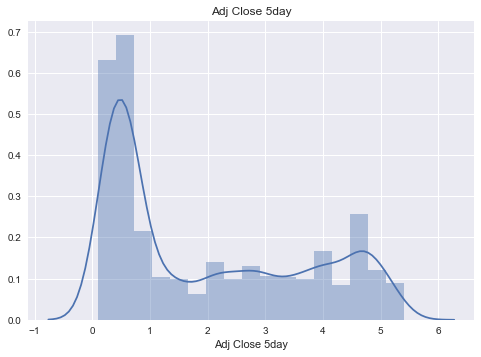

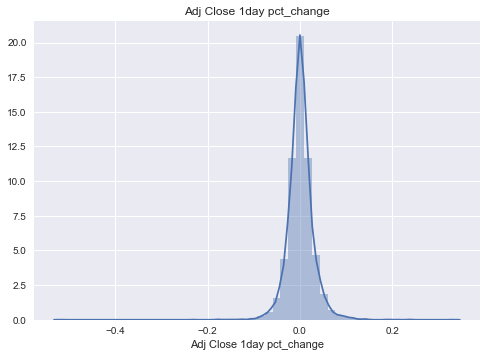

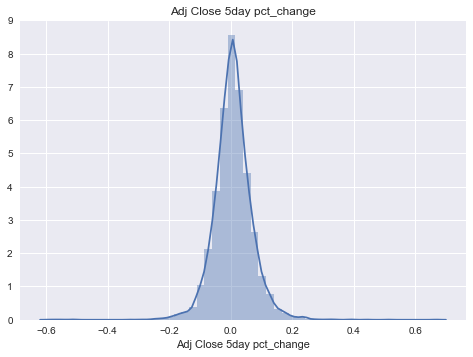

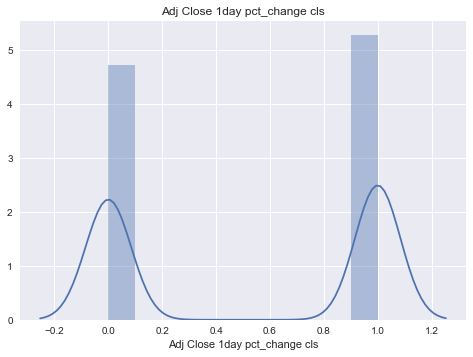

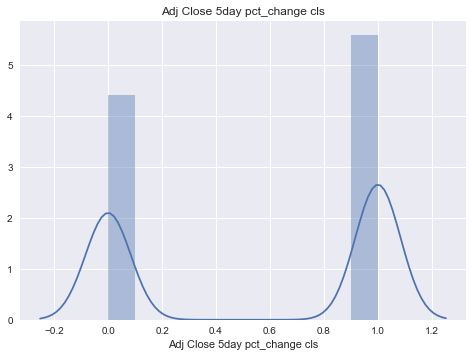

In [178]:
for column in df_y.columns:
    sns.distplot(df_y[column])
    plt.title(column)
    plt.show()

In [179]:
#PCA and PCA rand should look the same
print(PCA_X.describe())
PCA_X.head()

       Dimension 1   Dimension 2   Dimension 3   Dimension 4   Dimension 5  \
count  7213.000000  7.213000e+03  7.213000e+03  7.213000e+03  7.213000e+03   
mean      0.000000 -3.294129e-15 -2.679435e-15 -2.048979e-16  7.526059e-16   
std       2.440113  1.105713e+00  8.947255e-01  5.498842e-01  3.607879e-01   
min      -3.056276 -4.115505e+00 -2.249535e+00 -2.738588e+00 -1.488070e+00   
25%      -2.122125 -7.655524e-01 -6.725536e-01 -3.187549e-01 -2.435592e-01   
50%      -1.186725 -1.445692e-02 -7.281302e-02  4.424546e-02 -5.434978e-03   
75%       2.324788  7.423902e-01  5.905663e-01  3.435131e-01  2.400836e-01   
max       5.002538  4.155991e+00  3.140034e+00  5.721153e+00  3.303165e+00   

        Dimension 6   Dimension 7  
count  7.213000e+03  7.213000e+03  
mean   7.118788e-17 -1.414214e-16  
std    4.247506e-02  1.579046e-02  
min   -4.196019e-01 -7.048483e-03  
25%   -2.093469e-02 -2.137844e-03  
50%    5.735613e-04 -6.918661e-04  
75%    2.074227e-02  1.064949e-03  
max    6.

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7
0,-2.320605,-2.660764,1.034509,0.092653,0.406697,-0.035260,-0.003019
1,-2.418438,-1.918392,1.288252,-1.118660,0.367880,-0.001236,0.000675
2,-2.417139,-1.890593,1.305035,-1.173497,0.300376,0.029185,0.001111
3,-2.645091,-0.766996,-0.640920,-0.291383,-0.293602,0.071758,0.000441
4,-2.814456,-0.190551,-1.293837,-0.127284,0.020828,0.064103,-0.002212


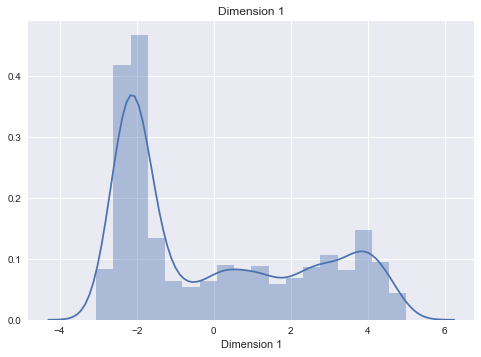

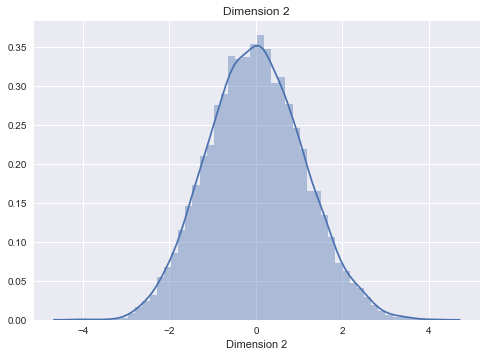

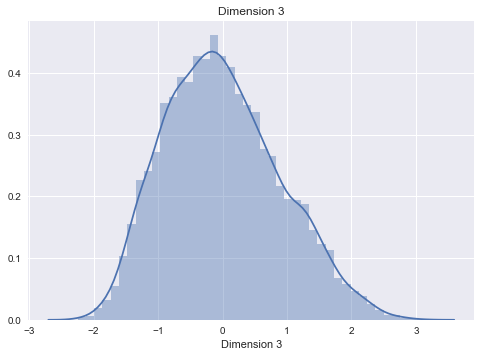

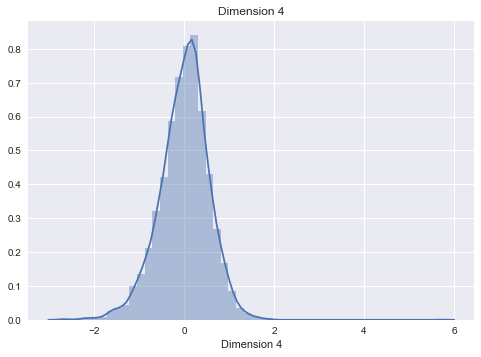

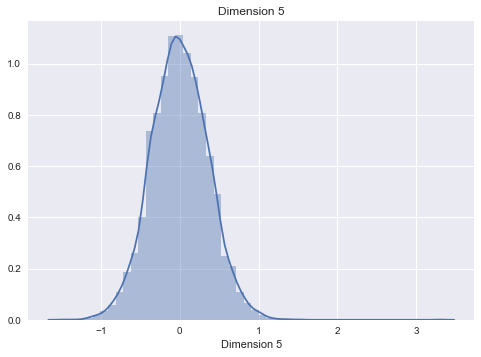

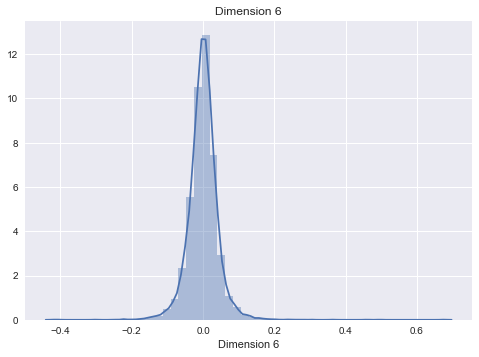

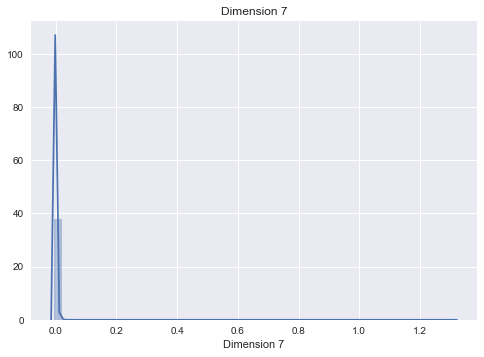

In [180]:
#note that the input to PCA has already been normalized/scaled prior to transformation
for column in PCA_X.columns:
    sns.distplot(PCA_X[column])
    plt.title(column)
    plt.show()

In [181]:
#PCA and PCA rand should look the same
print(PCA_y.describe())
PCA_y.head()

       Adj Close 1day  Adj Close 5day  Adj Close 1day pct_change  \
count     7213.000000     7213.000000                7213.000000   
mean         1.986597        1.989529                   0.001450   
std          1.696562        1.697883                   0.028554   
min          0.101524        0.101524                  -0.518691   
25%          0.506469        0.506830                  -0.012559   
50%          1.249979        1.254269                   0.000271   
75%          3.558811        3.562198                   0.014493   
max          5.388603        5.413021                   0.332279   

       Adj Close 5day pct_change  Adj Close 1day pct_change cls  \
count                7213.000000                    7213.000000   
mean                    0.007245                       0.527797   
std                     0.062772                       0.499261   
min                    -0.587617                       0.000000   
25%                    -0.026282                    

,Adj Close 1day,Adj Close 5day,Adj Close 1day pct_change,Adj Close 5day pct_change,Adj Close 1day pct_change cls,Adj Close 5day pct_change cls
0,0.112276,0.108951,-0.043186,-0.073093,0,0
1,0.107841,0.104130,-0.041668,-0.076392,0,0
2,0.107841,0.101524,0.000000,-0.061597,1,0
3,0.107100,0.107100,-0.007245,-0.007245,0,0
4,0.108951,0.104130,0.018241,-0.029201,1,0


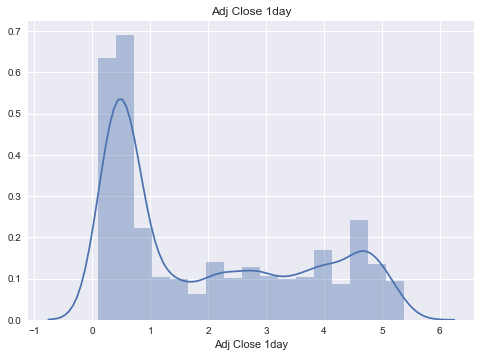

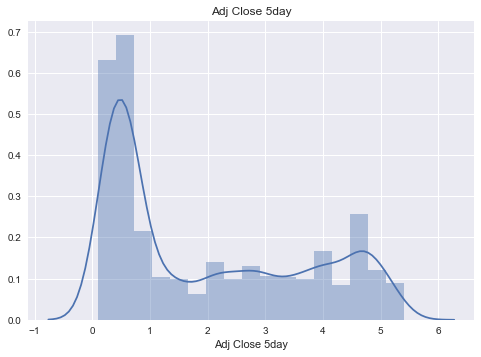

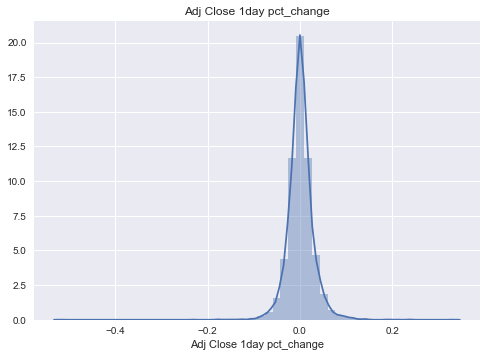

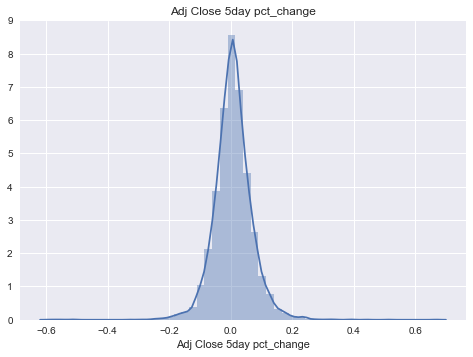

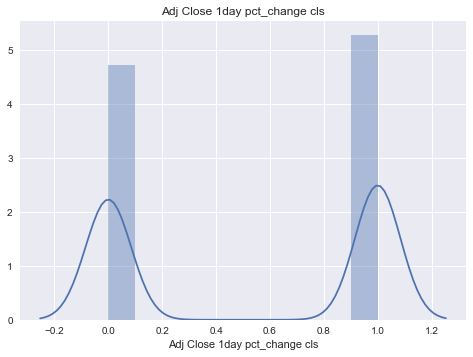

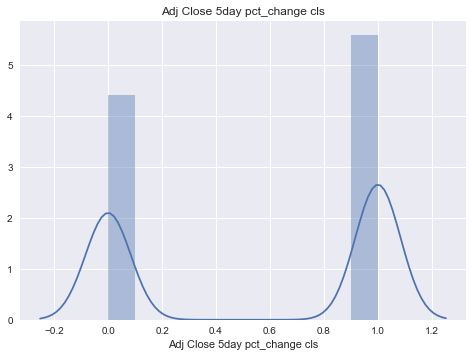

In [182]:
for column in PCA_y.columns:
    sns.distplot(PCA_y[column])
    plt.title(column)
    plt.show()

Let's split things into train, test and validations

In [183]:
#split into train, test, validation sets
PCA_rand_Xtrain, PCA_rand_Xtest, PCA_rand_ytrain, PCA_rand_ytest = train_test_split(PCA_rand_X, PCA_rand_y, test_size = 0.2)

n_split = int(len(df_y) * 0.8)
PCA_Xtrain, PCA_ytrain = np.array(PCA_X)[:n_split, :], np.array(PCA_y)[:n_split] 
PCA_Xtest, PCA_ytest = np.array(PCA_X)[n_split:, :], np.array(PCA_y)[n_split:]

df_rand_Xtrain, df_rand_Xtest, df_rand_ytrain, df_rand_ytest = train_test_split(df_rand_X, df_rand_y, test_size = 0.2)

df_Xtrain, df_ytrain = np.array(df_X)[:n_split, :], np.array(df_y)[:n_split] 
df_Xtest, df_ytest = np.array(df_X)[n_split:, :], np.array(df_y)[n_split:]

In [184]:
print(PCA_rand_Xtrain.shape, PCA_rand_Xtest.shape, PCA_rand_ytrain.shape, PCA_rand_ytest.shape)
print(PCA_Xtrain.shape, PCA_Xtest.shape, PCA_ytrain.shape, PCA_ytest.shape)

print(df_rand_Xtrain.shape, df_rand_Xtest.shape, df_rand_ytrain.shape, df_rand_ytest.shape)
print(df_Xtrain.shape, df_Xtest.shape, df_ytrain.shape, df_ytest.shape)

(5770, 7) (1443, 7) (5770, 6) (1443, 6)
(5770, 7) (1443, 7) (5770, 6) (1443, 6)
(5770, 10) (1443, 10) (5770, 6) (1443, 6)
(5770, 10) (1443, 10) (5770, 6) (1443, 6)


In [212]:
PCA_rand_ytrain.columns

Index(['Adj Close 1day', 'Adj Close 5day', 'Adj Close 1day pct_change',
       'Adj Close 5day pct_change', 'Adj Close 1day pct_change cls',
       'Adj Close 5day pct_change cls'],
      dtype='object')

Defind our performance measuring metrics, which will be RMSE for a regression exercise. For classification, let's just use accuracy.

In [185]:
def rmse(prediction, yval): #this method calculates the metrics
    return np.sqrt(mean_squared_error(prediction, yval))

Let's look at the benchmark model's performance. Starting with:
### Regression using Lasso

In [186]:
reg_benchmark = pd.DataFrame()
train_error = dict()
test_error = dict()

for i, target in enumerate(['Adj Close 1day', 'Adj Close 5day', 'Adj Close 1day pct_change', 'Adj Close 5day pct_change']):
    regressor = Lasso()
    regressor.fit(PCA_Xtrain, PCA_ytrain[:, i])
    train_error[target] = mean_squared_error(regressor.predict(PCA_Xtrain), PCA_ytrain[:, i]) / np.mean(PCA_ytrain[:, i]) * 100
    test_error[target] = mean_squared_error(regressor.predict(PCA_Xtest), PCA_ytest[:, i]) / np.mean(PCA_ytest[:, i]) * 100

reg_benchmark['PCA train benchmark'] = pd.Series(train_error)
reg_benchmark['PCA test benchmark'] = pd.Series(test_error)

In [187]:
train_error = dict()
test_error = dict()

for i, target in enumerate(['Adj Close 1day', 'Adj Close 5day', 'Adj Close 1day pct_change', 'Adj Close 5day pct_change']):
    regressor = Lasso()
    regressor.fit(PCA_rand_Xtrain, PCA_rand_ytrain[target])
    train_error[target] = mean_squared_error(regressor.predict(PCA_rand_Xtrain), PCA_rand_ytrain[target]) / np.mean(PCA_rand_ytrain[target]) * 100
    test_error[target] = mean_squared_error(regressor.predict(PCA_rand_Xtest), PCA_rand_ytest[target]) / np.mean(PCA_rand_ytest[target]) * 100

reg_benchmark['PCA rand train benchmark'] = pd.Series(train_error)
reg_benchmark['PCA rand test benchmark'] = pd.Series(test_error)

In [188]:
train_error = dict()
test_error = dict()

for i, target in enumerate(['Adj Close 1day', 'Adj Close 5day', 'Adj Close 1day pct_change', 'Adj Close 5day pct_change']):
    regressor = Lasso()
    regressor.fit(df_Xtrain, df_ytrain[:, i])
    train_error[target] = mean_squared_error(regressor.predict(df_Xtrain), df_ytrain[:, i]) / np.mean(df_ytrain[:, i]) * 100
    test_error[target] = mean_squared_error(regressor.predict(df_Xtest), df_ytest[:, i]) / np.mean(df_ytest[:, i]) * 100

reg_benchmark['df train benchmark'] = pd.Series(train_error)
reg_benchmark['df test benchmark'] = pd.Series(test_error)

In [189]:
train_error = dict()
test_error = dict()

for i, target in enumerate(['Adj Close 1day', 'Adj Close 5day', 'Adj Close 1day pct_change', 'Adj Close 5day pct_change']):
    regressor = Lasso()
    regressor.fit(df_rand_Xtrain, df_rand_ytrain[target])
    train_error[target] = mean_squared_error(regressor.predict(df_rand_Xtrain), df_rand_ytrain[target]) / np.mean(df_rand_ytrain[target]) * 100
    test_error[target] = mean_squared_error(regressor.predict(df_rand_Xtest), df_rand_ytest[target]) / np.mean(df_rand_ytest[target]) * 100

reg_benchmark['df rand train benchmark'] = pd.Series(train_error)
reg_benchmark['df rand test benchmark'] = pd.Series(test_error)

In [190]:
print('These are my benchmark:')
reg_benchmark.transpose()

These are my benchmark:


,Adj Close 1day,Adj Close 1day pct_change,Adj Close 5day,Adj Close 5day pct_change
PCA train benchmark,27.530294,61.462004,27.562171,59.401281
PCA test benchmark,60.961951,23.648944,60.734284,24.350404
PCA rand train benchmark,9.127360,56.541239,9.178331,58.015818
PCA rand test benchmark,9.013509,54.917611,9.013173,42.312645
df train benchmark,54.328296,61.462004,54.314282,59.401281
df test benchmark,123.717315,23.648944,123.368594,24.350404
df rand train benchmark,17.890476,57.801619,17.927187,54.473760
df rand test benchmark,18.290212,51.754370,18.290738,53.985356


Doesn't seem like the pct_changes are converging. we may need a different algo for these

In [195]:
#1. Lasso Regression
def Lasso_GSCV(Xtrain, ytrain, Xval, yval):
    '''

    '''
    print('Lasso GridSearchCV: ', strftime('%d %b %Y %H:%M:%S', gmtime()))
    params = {'alpha': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01],
              'max_iter': [2, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]}
    
    cv_sets = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
    t0 = time()

    regressor = Lasso()
    grid = GridSearchCV(estimator = regressor, param_grid = params,
                        scoring = 'neg_mean_squared_error', cv = cv_sets, verbose = 1)
    
    grid = grid.fit(Xtrain, ytrain)
    
    test_score = mean_squared_error(grid.predict(Xval), yval) / np.mean(yval) * 100
    
    print('Algo takes: {:.3f} seconds'.format(time() - t0))
    #print(test_score)
    
    train_error = mean_squared_error(grid.predict(Xtrain), ytrain) / np.mean(ytrain) * 100
    
    #print(grid.best_score_)
    #print(grid.best_estimator_)
    #print(grid.cv_results_)
    return grid.best_estimator_, train_error, test_score

In [207]:
results = reg_benchmark.copy()

estimator_info = dict()
train_error = dict()
test_error = dict()

for i, target in enumerate(['Adj Close 1day', 'Adj Close 5day', 'Adj Close 1day pct_change', 'Adj Close 5day pct_change']):
    estimator_info[target], train_error[target], test_error[target] = Lasso_GSCV(PCA_Xtrain, PCA_ytrain[:, i], PCA_Xtest, PCA_ytest[:, i])

results['PCA train'] = pd.Series(train_error)
results['PCA test'] = pd.Series(test_error)

estimator_info

Lasso GridSearchCV:  31 Aug 2018 23:06:00
Fitting 5 folds for each of 80 candidates, totalling 400 fits


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.8s finished
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\use

Algo takes: 0.932 seconds
Lasso GridSearchCV:  31 Aug 2018 23:06:01
Fitting 5 folds for each of 80 candidates, totalling 400 fits


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

Algo takes: 1.102 seconds
Lasso GridSearchCV:  31 Aug 2018 23:06:02
Fitting 5 folds for each of 80 candidates, totalling 400 fits


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

Algo takes: 1.013 seconds
Lasso GridSearchCV:  31 Aug 2018 23:06:03
Fitting 5 folds for each of 80 candidates, totalling 400 fits


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

Algo takes: 1.126 seconds


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.0s finished


{'Adj Close 1day': Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=10.0,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False),
 'Adj Close 1day pct_change': Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=2,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False),
 'Adj Close 5day': Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=10.0,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False),
 'Adj Close 5day pct_change': Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=2,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False)}

In [208]:
estimator_info = dict()
train_error = dict()
test_error = dict()

for i, target in enumerate(['Adj Close 1day', 'Adj Close 5day', 'Adj Close 1day pct_change', 'Adj Close 5day pct_change']):
    estimator_info[target], train_error[target], test_error[target] = Lasso_GSCV(PCA_rand_Xtrain, PCA_rand_ytrain[target], PCA_rand_Xtest, PCA_rand_ytest[target])

results['PCA rand train'] = pd.Series(train_error)
results['PCA rand test'] = pd.Series(test_error)

estimator_info

Lasso GridSearchCV:  31 Aug 2018 23:06:55
Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.5s finished
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\use

Algo takes: 2.648 seconds
Lasso GridSearchCV:  31 Aug 2018 23:06:57
Fitting 5 folds for each of 80 candidates, totalling 400 fits


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

Algo takes: 2.667 seconds
Lasso GridSearchCV:  31 Aug 2018 23:07:00
Fitting 5 folds for each of 80 candidates, totalling 400 fits


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

Algo takes: 2.860 seconds
Lasso GridSearchCV:  31 Aug 2018 23:07:03
Fitting 5 folds for each of 80 candidates, totalling 400 fits


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

Algo takes: 2.629 seconds


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.5s finished


{'Adj Close 1day': Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=10.0,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False),
 'Adj Close 1day pct_change': Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=2,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False),
 'Adj Close 5day': Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=2,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False),
 'Adj Close 5day pct_change': Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=2,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False)}

In [209]:
estimator_info = dict()
train_error = dict()
test_error = dict()

for i, target in enumerate(['Adj Close 1day', 'Adj Close 5day', 'Adj Close 1day pct_change', 'Adj Close 5day pct_change']):
    estimator_info[target], train_error[target], test_error[target] = Lasso_GSCV(df_Xtrain, df_ytrain[:, i], df_Xtest, df_ytest[:, i])

results['df train'] = pd.Series(train_error)
results['df test'] = pd.Series(test_error)

estimator_info

Lasso GridSearchCV:  31 Aug 2018 23:07:16
Fitting 5 folds for each of 80 candidates, totalling 400 fits


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

Algo takes: 240.785 seconds
Lasso GridSearchCV:  31 Aug 2018 23:11:17
Fitting 5 folds for each of 80 candidates, totalling 400 fits


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  9.6min finished


Algo takes: 576.409 seconds
Lasso GridSearchCV:  31 Aug 2018 23:20:53
Fitting 5 folds for each of 80 candidates, totalling 400 fits


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  9.8min finished
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\use

Algo takes: 588.611 seconds
Lasso GridSearchCV:  31 Aug 2018 23:30:42
Fitting 5 folds for each of 80 candidates, totalling 400 fits


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

Algo takes: 694.526 seconds


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 11.6min finished


{'Adj Close 1day': Lasso(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=100.0,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False),
 'Adj Close 1day pct_change': Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=2,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False),
 'Adj Close 5day': Lasso(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=100000.0,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False),
 'Adj Close 5day pct_change': Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=2,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False)}

In [210]:
estimator_info = dict()
train_error = dict()
test_error = dict()

for i, target in enumerate(['Adj Close 1day', 'Adj Close 5day', 'Adj Close 1day pct_change', 'Adj Close 5day pct_change']):
    estimator_info[target], train_error[target], test_error[target] = Lasso_GSCV(df_rand_Xtrain, df_rand_ytrain[target], df_rand_Xtest, df_rand_ytest[target])

results['df rand train'] = pd.Series(train_error)
results['df rand test'] = pd.Series(test_error)
estimator_info

Lasso GridSearchCV:  01 Sep 2018 05:52:35
Fitting 5 folds for each of 80 candidates, totalling 400 fits


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

Algo takes: 3.326 seconds
Lasso GridSearchCV:  01 Sep 2018 05:52:38
Fitting 5 folds for each of 80 candidates, totalling 400 fits


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

Algo takes: 576.118 seconds
Lasso GridSearchCV:  01 Sep 2018 06:02:14
Fitting 5 folds for each of 80 candidates, totalling 400 fits


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

Algo takes: 703.143 seconds
Lasso GridSearchCV:  01 Sep 2018 06:13:57
Fitting 5 folds for each of 80 candidates, totalling 400 fits


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\skle

Algo takes: 872.650 seconds


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 14.5min finished


{'Adj Close 1day': Lasso(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=100.0,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False),
 'Adj Close 1day pct_change': Lasso(alpha=1e-06, copy_X=True, fit_intercept=True, max_iter=1000.0,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False),
 'Adj Close 5day': Lasso(alpha=1e-10, copy_X=True, fit_intercept=True, max_iter=1000000.0,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False),
 'Adj Close 5day pct_change': Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=2,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False)}

In [201]:
print('These are my benchmark:')
results.transpose()

These are my benchmark:


,Adj Close 1day,Adj Close 1day pct_change,Adj Close 5day,Adj Close 5day pct_change
PCA train benchmark,27.530294,61.462004,27.562171,59.401281
PCA test benchmark,60.961951,23.648944,60.734284,24.350404
PCA rand train benchmark,9.127360,56.541239,9.178331,58.015818
PCA rand test benchmark,9.013509,54.917611,9.013173,42.312645
df train benchmark,54.328296,61.462004,54.314282,59.401281
df test benchmark,123.717315,23.648944,123.368594,24.350404
df rand train benchmark,17.890476,57.801619,17.927187,54.473760
df rand test benchmark,18.290212,51.754370,18.290738,53.985356
PCA train,0.027417,61.462004,0.126365,59.401281
PCA test,0.005565,23.648944,0.027345,24.350404


In [241]:
clf_benchmark = pd.DataFrame()
train_error = dict()
test_error = dict()

for i, target in enumerate(['Adj Close 1day pct_change cls', 'Adj Close 5day pct_change cls']):
    classifier = xgb.XGBClassifier()
    classifier.fit(PCA_Xtrain, PCA_ytrain[:, i+4])
    train_error[target] = accuracy_score(classifier.predict(PCA_Xtrain), PCA_ytrain[:, i+4]) * 100
    test_error[target] = accuracy_score(classifier.predict(PCA_Xtest), PCA_ytest[:, i+4]) * 100

clf_benchmark['PCA train benchmark'] = pd.Series(train_error)
clf_benchmark['PCA test benchmark'] = pd.Series(test_error)

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

In [242]:
train_error = dict()
test_error = dict()

for i, target in enumerate(['Adj Close 1day pct_change cls', 'Adj Close 5day pct_change cls']):
    classifier = xgb.XGBClassifier()
    classifier.fit(PCA_rand_Xtrain, PCA_rand_ytrain[target])
    train_error[target] = accuracy_score(classifier.predict(PCA_rand_Xtrain), PCA_rand_ytrain[target]) * 100
    test_error[target] = accuracy_score(classifier.predict(PCA_rand_Xtest), PCA_rand_ytest[target]) * 100

clf_benchmark['PCA rand train benchmark'] = pd.Series(train_error)
clf_benchmark['PCA rand test benchmark'] = pd.Series(test_error)

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

In [243]:
train_error = dict()
test_error = dict()

for i, target in enumerate(['Adj Close 1day pct_change cls', 'Adj Close 5day pct_change cls']):
    classifier = xgb.XGBClassifier()
    classifier.fit(df_Xtrain, df_ytrain[:, i+4])
    train_error[target] = accuracy_score(classifier.predict(df_Xtrain), df_ytrain[:, i+4]) * 100
    test_error[target] = accuracy_score(classifier.predict(df_Xtest), df_ytest[:, i+4]) * 100

clf_benchmark['df train benchmark'] = pd.Series(train_error)
clf_benchmark['df test benchmark'] = pd.Series(test_error)

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

In [244]:
train_error = dict()
test_error = dict()

for i, target in enumerate(['Adj Close 1day pct_change cls', 'Adj Close 5day pct_change cls']):
    classifier = xgb.XGBClassifier()
    classifier.fit(df_rand_Xtrain, df_rand_ytrain[target])
    train_error[target] = accuracy_score(classifier.predict(df_rand_Xtrain), df_rand_ytrain[target]) * 100
    test_error[target] = accuracy_score(classifier.predict(df_rand_Xtest), df_rand_ytest[target]) * 100

clf_benchmark['df rand train benchmark'] = pd.Series(train_error)
clf_benchmark['df rand test benchmark'] = pd.Series(test_error)

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

In [245]:
clf_benchmark.transpose()

,Adj Close 1day pct_change cls,Adj Close 5day pct_change cls
PCA train benchmark,65.528596,64.523397
PCA test benchmark,50.519751,45.530146
PCA rand train benchmark,66.811092,63.223570
PCA rand test benchmark,50.727651,55.370755
df train benchmark,65.164645,66.187175
df test benchmark,50.450450,52.598753
df rand train benchmark,65.753899,66.343154
df rand test benchmark,54.331254,58.627859


In [246]:
def XGBR_GSCV(Xtrain, ytrain, Xval, yval):
    '''
    params = {'reg_alpha': [0.00001, 0.000025, 0.00005,0.000075,
                        0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007,
                        0.0008, 0.0009, 0.001, 0.0025, 0.005],
              'n_estimators': range(1500, 5000, 100),
              'learning_rate': [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065,
                                0.07, 0.075, 0.08, 0.085, 0.09, 0.1],
              'max_depth': range(1, 10)}
  
    '''
    print('XGBoost GridSearchCV: ', strftime('%d %b %Y %H:%M:%S', gmtime()))
    params = {'learning_rate': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
              'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
              'n_estimators': [600, 700, 800, 900, 1000, 1100, 1200, 1300],
              'reg_alpha': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}
    
    cv_sets = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
    clfier = xgb.XGBClassifier()
    acc_scorer = make_scorer(accuracy_score)
    t0 = time()
    grid = GridSearchCV(estimator = clfier, param_grid = params,
                        scoring = acc_scorer, cv = cv_sets, verbose = 1)
    
    grid = grid.fit(Xtrain, ytrain)

    test_score = accuracy_score(grid.predict(Xval), yval) * 100
    train_score = accuracy_score(grid.predict(Xtrain), ytrain) * 100
    

    return grid.best_estimator_, train_error, test_score

In [ ]:
results = clf_benchmark.copy()

estimator_info = dict()
train_error = dict()
test_error = dict()

for i, target in enumerate(['Adj Close 1day pct_change cls', 'Adj Close 5day pct_change cls']):
    estimator_info[target], train_error[target], test_error[target] = XGBR_GSCV(PCA_Xtrain, PCA_ytrain[:, i+4], PCA_Xtest, PCA_ytest[:, i+4])

results['PCA train'] = pd.Series(train_error)
results['PCA test'] = pd.Series(test_error)

estimator_info

XGBoost GridSearchCV:  02 Sep 2018 05:33:30
Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

In [ ]:
results = benchmark.copy()

estimator_info = dict()
train_error = dict()
test_error = dict()

for i, target in enumerate(['Adj Close 1day pct_change cls', 'Adj Close 5day pct_change cls']):
    estimator_info[target], train_error[target], test_error[target] = xgb.XGBClassifier(PCA_Xtrain, PCA_ytrain[:, i], PCA_Xtest, PCA_ytest[:, i])

results['PCA train'] = pd.Series(train_error)
results['PCA test'] = pd.Series(test_error)

estimator_info

In [ ]:
def XGBR_optimize(Xtrain, Xval, ytrain, yval):
    '''
    params = {'reg_alpha': [0.00001, 0.000025, 0.00005,0.000075,
                        0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007,
                        0.0008, 0.0009, 0.001, 0.0025, 0.005],
              'n_estimators': range(1500, 5000, 100),
              'learning_rate': [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065,
                                0.07, 0.075, 0.08, 0.085, 0.09, 0.1],
              'max_depth': range(1, 10)}
  
    '''
    print('XGBoost GridSearchCV: ', strftime('%d %b %Y %H:%M:%S', gmtime()))
    t0 = time()
    clfier = xgb.XGBClassifier(learning_rate = 0.001, max_depth = 5, n_estimators = 1000,
                               reg_alpha = 0.001)
    clfier.fit(Xtrain, ytrain)
    
    print('Time algo takes: {:.3f} seconds'.format(time() - t0))
    print('Train accuracy: {:.4f}'.format(accuracy_score(clfier.predict(Xtrain), ytrain)))
    print('Test accuracy: {:.4f}'.format(accuracy_score(clfier.predict(Xval), yval)))
    
    pass

In [ ]:
def window_transform_series(X, y, window_size):
    # containers for input/output pairs
    X_result = []
    y_result = []
    #print(series)
    #print(window_size)
    for i in range(len(y) - window_size):
        X_result.append(X[i: i + window_size])
        y_result.append(y[i + window_size])
        #print(i)
        #print(series[i: i + window_size])
        #print(series[i + window_size])
    # reshape each

    X_result = np.asarray(X_result)
    X_result.shape = (np.shape(X_result)[0:3])

    y_result = np.asarray(y_result)
    y_result.shape = (len(y_result), 1)

    return X_result, y_result

In [ ]:
#is it a good idea to tune LSTM using gridsearchCV??
#https://machinelearningmastery.com/tune-lstm-hyperparameters-keras-time-series-forecasting/
def LSTM_optimize1(Xtrain, Xtest, ytrain, ytest, neurons, batch_size, epochs, repeat): #algorithms = , n_neighbors =
    #there are a couple of things we can vary:
    #1. epochs: seem that 150 works best
    #2. neurons: doesn't seem like it matters for single layer
    #3. batch_size: doesn't seem like it matters for single layer
    error_train = []
    error_test = []
    good_size = Xtrain.shape[0] - Xtrain.shape[0] % batch_size
    Xtrain = Xtrain[-good_size:]
    ytrain = ytrain[-good_size:]
    
    good_size = Xtest.shape[0] - Xtest.shape[0] % batch_size
    Xtest = Xtest[-good_size:]
    ytest = ytest[-good_size:]
    
    for i in range(repeat):
        model = Sequential()
        model.add(LSTM(neurons, batch_input_shape = (batch_size, Xtrain.shape[1], Xtrain.shape[2]), stateful = True))
        model.add(Dense(1))
        model.compile(loss = 'mean_squared_error', optimizer = 'adam')
        model.fit(Xtrain, ytrain, epochs = epochs, batch_size = batch_size, verbose = 0, shuffle = False)
        
        rmse_train = np.sqrt(mean_squared_error(model.predict(Xtrain, batch_size = batch_size), ytrain))
        rmse_test = np.sqrt(mean_squared_error(model.predict(Xtest, batch_size = batch_size), ytest))
        error_train.append(rmse_train)
        error_test.append(rmse_test)
        model.reset_states()
    return error_train, error_test

In [ ]:
#another reference: https://machinelearningmastery.com/stacked-long-short-term-memory-networks/
def LSTM_optimize2(Xtrain, Xtest, ytrain, ytest, neurons1, neurons2,
                   batch_size, epochs, repeat): #algorithms = , n_neighbors =
    #there are a couple of things we can vary:
    #1. epochs: 
    #2. neurons: 
    #3. batch_size: 
    #4. layers:
    error_train = []
    error_test = []
    good_size = Xtrain.shape[0] - Xtrain.shape[0] % batch_size
    Xtrain = Xtrain[-good_size:]
    ytrain = ytrain[-good_size:]
    
    good_size = Xtest.shape[0] - Xtest.shape[0] % batch_size
    Xtest = Xtest[-good_size:]
    ytest = ytest[-good_size:]
    
    for i in range(repeat):
        model = Sequential()
        model.add(LSTM(neurons1, batch_input_shape = (batch_size, Xtrain.shape[1], Xtrain.shape[2]),
                       stateful = True, return_sequences = True))
        model.add(LSTM(neurons2))
        model.add(Dense(1))
        model.compile(loss = 'mean_squared_error', optimizer = 'adam')
        model.fit(Xtrain, ytrain, epochs = epochs, batch_size = batch_size, verbose = 0, shuffle = False)
        
        rmse_train = np.sqrt(mean_squared_error(model.predict(Xtrain, batch_size = batch_size), ytrain))
        rmse_test = np.sqrt(mean_squared_error(model.predict(Xtest, batch_size = batch_size), ytest))
        error_train.append(rmse_train)
        error_test.append(rmse_test)
        model.reset_states()
    return error_train, error_test

''' my target variables
0:'Adj Close 1day'
1:'Adj Close 5day'
2:'Adj Close 1day pct_change'
3:'Adj Close 5day pct_change'
4:'Adj Close 1day pct_change cls'
5:'Adj Close 5day pct_change cls'
'''

In [ ]:
#benchmark models: get a rough idea on what type of error/accuracy we can achieve
if False: #Lasso Regression: run grid search cross validation to find the best parameters 
    variable = 'Adj Close 5day pct_change'
    results_dict = Lasso_GSCV(PCA_rand_Xtrain,
                              PCA_rand_Xtest,
                              PCA_rand_ytrain[variable],
                              PCA_rand_ytest[variable])


    result = pd.DataFrame()
    result['param_max_iter'] = results_dict['param_max_iter'].data
    result['param_alpha'] = results_dict['param_alpha'].data
    result['mean_train_score'] = results_dict['mean_train_score'].data
    result['mean_test_score'] = results_dict['mean_test_score'].data

    param_max_iter = result.groupby('param_max_iter').mean()
    param_max_iter['train avg'] = result.groupby('param_max_iter').mean()['mean_train_score']/df_rand_ytrain[variable].mean()
    param_max_iter['test avg'] = result.groupby('param_max_iter').mean()['mean_test_score']/df_rand_ytest[variable].mean()

    param_alpha = result.groupby('param_alpha').mean()
    param_alpha['train avg'] = result.groupby('param_alpha').mean()['mean_train_score']/df_rand_ytrain[variable].mean()
    param_alpha['test avg'] = result.groupby('param_alpha').mean()['mean_test_score']/df_rand_ytest[variable].mean()

    print('param_max_iter')
    print(param_max_iter)
    print('param_alpha')
    print(param_alpha)

In [ ]:
if False: #Get the best possible results from Lasso Regression
    variable = 'Adj Close 5day pct_change'
    Lasso_optimize(PCA_rand_Xtrain,
                   PCA_rand_Xtest,
                   PCA_rand_ytrain[variable],
                   PCA_rand_ytest[variable])

    #no PCA
    #'Adj Close 1day': achieving Train error: 0.0206 (0.74%), Test error: 0.0195 (0.72%)
    #'Adj Close 5day': achieving Train error: 0.0444 (1.59%), Test error: 0.0477 (1.73%)
    #'Adj Close 1day pct_change': achieving Train error: 0.0246 (1640.96%), Test error: 0.0311 (6591.40%)
    #'Adj Close 5day pct_change': achieving Train error: 0.0572 (894.90%), Test error: 0.0528 (816.17%)

    #with PCA
    #'Adj Close 1day': achieving Train error: 0.0197 (0.71%), Test error: 0.0250 (0.88%)
    #'Adj Close 5day': achieving Train error: 0.0448 (1.60%), Test error: 0.0469 (1.75%)
    #'Adj Close 1day pct_change': achieving Train error: 0.0263 (2113.21%), Test error: 0.0247 (1672.30%)
    #'Adj Close 5day pct_change': achieving Train error: 0.0578 (840.08%), Test error: 0.0500 (1109.72%)

In [ ]:
if False: #XGBoost Classification: run grid search cross validation to find the best parameters 
    variable = 'Adj Close 5day pct_change cls'
    results_dict = XGBR_GSCV(PCA_rand_Xtrain,
                             PCA_rand_Xtest,
                             PCA_rand_ytrain[variable],
                             PCA_rand_ytest[variable])

    result = pd.DataFrame()

    result['param_learning_rate'] = results_dict['param_learning_rate'].data
    result['param_max_depth'] = results_dict['param_max_depth'].data
    result['param_n_estimators'] = results_dict['param_n_estimators'].data
    result['param_reg_alpha'] = results_dict['param_reg_alpha'].data

    result['mean_train_score'] = results_dict['mean_train_score'].data
    result['mean_test_score'] = results_dict['mean_test_score'].data

    param_learning_rate = result.groupby('param_learning_rate').mean()
    param_max_depth = result.groupby('param_max_depth').mean()
    param_n_estimators = result.groupby('param_n_estimators').mean()
    param_reg_alpha = result.groupby('param_reg_alpha').mean()

    print('param_learning_rate')
    print(param_learning_rate)
    print('param_max_depth')
    print(param_max_depth)
    print('param_n_estimators')
    print(param_n_estimators)
    print('param_reg_alpha')
    print(param_reg_alpha)

In [ ]:
if False: #Get the best possible results from XGBoost Classifier
    variable = 'Adj Close 1day pct_change cls'
    XGBR_optimize(df_rand_Xtrain,
                  df_rand_Xtest,
                  df_rand_ytrain[variable],
                  df_rand_ytest[variable])

    #no PCA
    #'Adj Close 1day pct_change cls': achieving Train accuracy: 0.5990, Test accuracy: 0.5011
    #'Adj Close 5day pct_change cls': achieving Train accuracy: 0.6457, Test accuracy: 0.5884

    #with PCA
    #'Adj Close 1day pct_change cls': achieving Train accuracy: 0.6476, Test accuracy: 0.5338
    #'Adj Close 5day pct_change cls': achieving Train accuracy: 0.6591, Test accuracy: 0.5611


In [ ]:
#LSTM
if True:
    window_size = 5
    X_train, y_train = window_transform_series(df_Xtrain, df_ytrain[:, 2], window_size = window_size)
    X_test, y_test = window_transform_series(df_Xtest, df_ytest[:, 2], window_size = window_size)

    # X_train.shape: (3656, 5, 10) and y_train.shape: (3656, 1)
    #3656 is the number of rows, 5 is the batch_size/window_size, 10 is the number of features

    # NOTE: to use keras's RNN LSTM module our input must be reshaped to [samples, window size, stepsize]
    #test epochs first

    
    neurons1 = [5, 10, 15, 20, 25]
    neurons2 = [5, 10, 15, 20, 25]
    epochs = [400, 600, 800, 1000]
    batch_size = [500]
    train_results = dict()
    test_results = dict()

    for n1 in neurons1:
        for n2 in neurons2:
            for e in epochs:
                for b in batch_size:
                    t0 = time()
                    train_result = pd.DataFrame()
                    test_result = pd.DataFrame()
                    train_result, test_result = LSTM_optimize2(X_train, X_test, y_train, y_test,
                                                               neurons1 = n1, neurons2 = n2,
                                                               batch_size = b, epochs = e, repeat = 1)
                    print('layer1 {} neurons, layer2 {} neurons, {} batches, finished with {} epochs, took {} seconds'.format(n1, n2, b, e, time() - t0))
                    train_results[(n1, n2, e, b)] = train_result
                    test_results[(n1, n2, e, b)] = test_result
            
        
    print('train errors')
    for key in train_results.keys():
        print(key, train_results[key])
        
    print('test errors')
    for key in test_results.keys():
        print(key, test_results[key])
